# Causal Trees/Forests Interpretation with Feature Importance and SHAP Values

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import multiprocessing as mp

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Currently causalml shap support is experimental and is available by installing from source
# PR: https://github.com/shap/shap/pull/3273
import shap

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor
from causalml.inference.tree.utils import timeit

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

Failed to import duecredit due to No module named 'duecredit'


In [3]:
import importlib
for libname in ["causalml", "shap"]:
    print(f"{libname}: {importlib.metadata.version(libname)}")

causalml: 0.15.3
shap: 0.40.1.dev831


In [4]:
# Simulate randomized trial: mode=2
y, X, w, tau, b, e = synthetic_data(mode=2, n=2000, p=10, sigma=3.0)

df = pd.DataFrame(X)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df.columns = feature_names
df['outcome'] = y
df['treatment'] = w
df['treatment_effect'] = tau

In [5]:
# Split data to training and testing samples for model validation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
n_train, n_test = df_train.shape[0], df_test.shape[0]

X_train, y_train = df_train[feature_names], df_train['outcome'].values
X_test, y_test = df_test[feature_names], df_test['outcome'].values
treatment_train, treatment_test = df_train['treatment'].values, df_test['treatment'].values
effect_test = df_test['treatment_effect'].values

observation = X_test.loc[[0]]

#### CausalTreeRegressor

In [6]:
ctree = CausalTreeRegressor()
ctree.fit(X=X_train.values, y=y_train, treatment=treatment_train)

CausalTreeRegressor()

#### CausalRandomForestRegressor

In [7]:
crforest = CausalRandomForestRegressor(criterion="causal_mse",
                                  min_samples_leaf=200,
                                  control_name=0,
                                  n_estimators=50,
                                  n_jobs=mp.cpu_count() - 1)
crforest.fit(X=X_train, y=y_train, treatment=treatment_train)

CausalRandomForestRegressor(min_samples_leaf=200, n_estimators=50, n_jobs=11)

### 1. Impurity-based feature importance

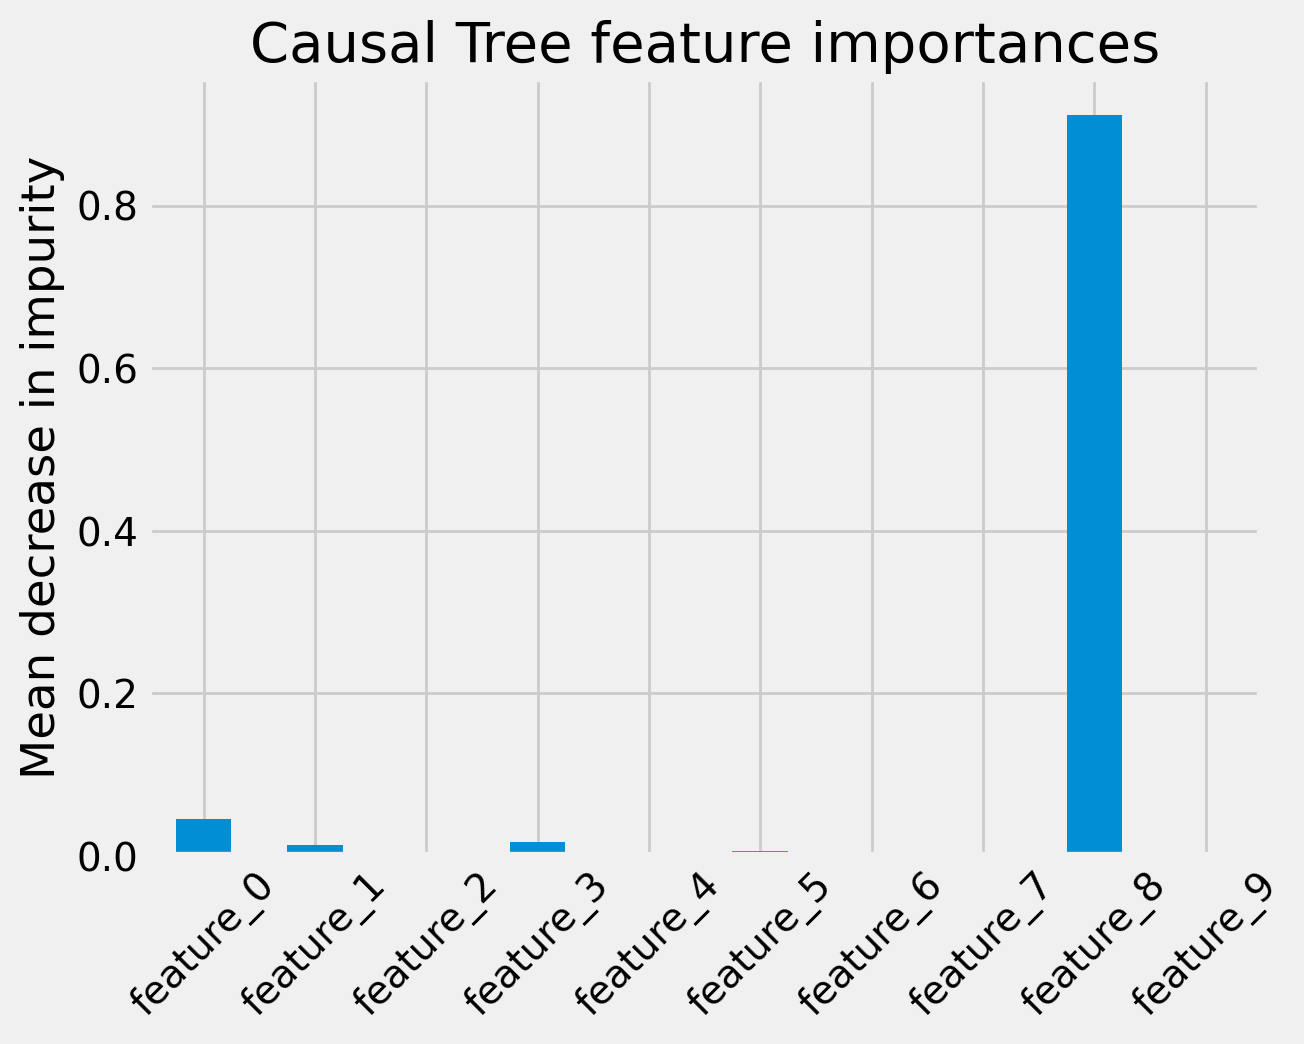

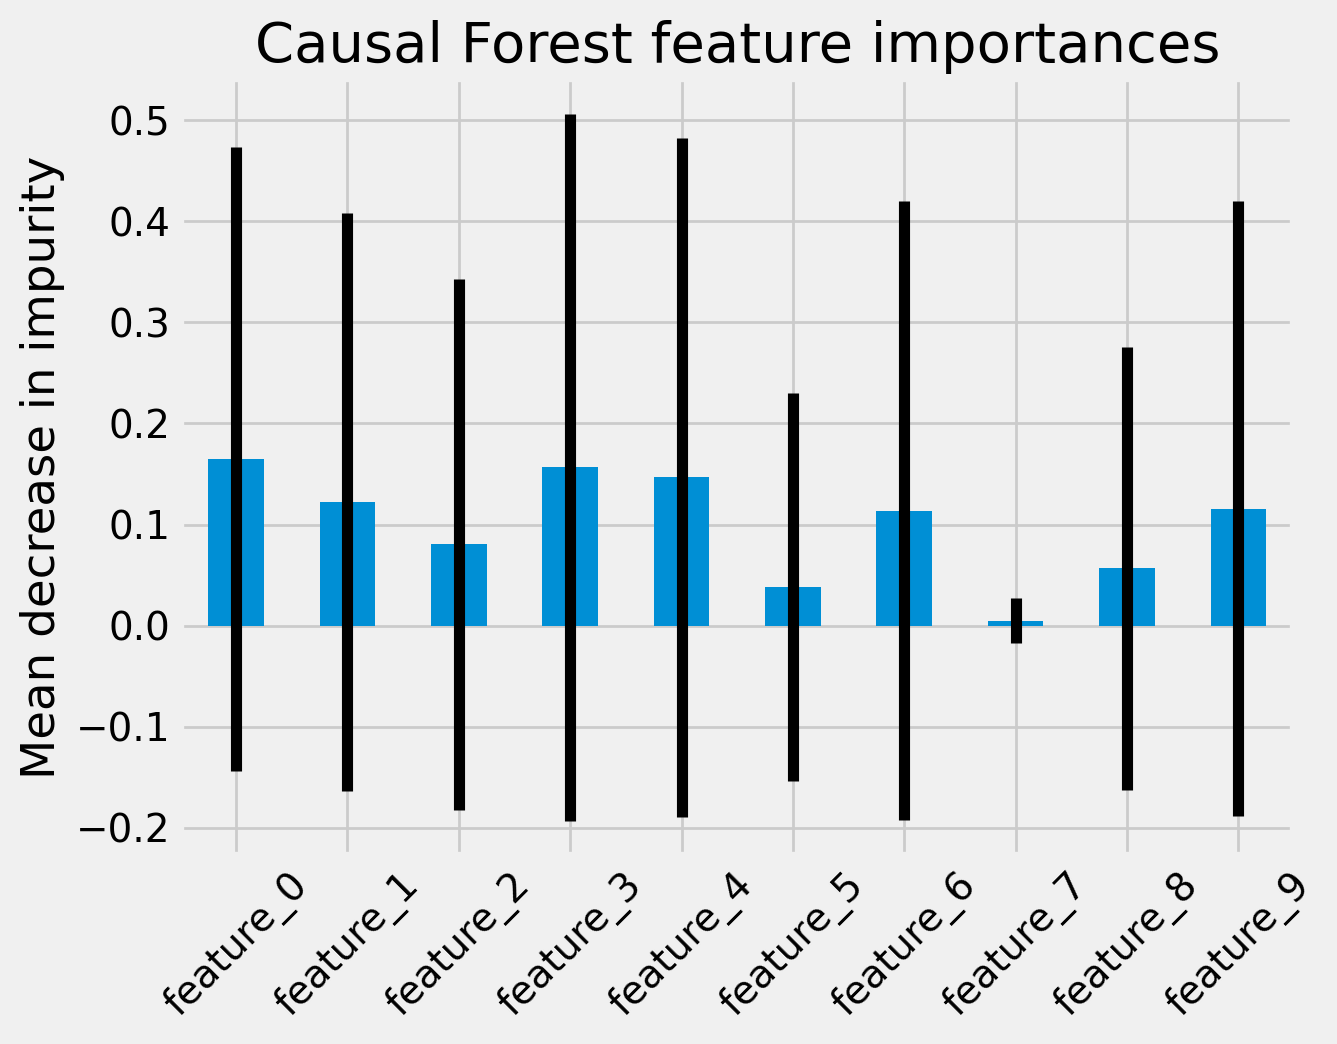

In [8]:
df_importances = pd.DataFrame({'tree': ctree.feature_importances_, 
                               'forest': crforest.feature_importances_,
                               'feature': feature_names
                              })
forest_std = np.std([tree.feature_importances_ for tree in crforest.estimators_], axis=0)

fig, ax = plt.subplots()
df_importances['tree'].plot.bar(ax=ax)
ax.set_title("Causal Tree feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

fig, ax = plt.subplots()
df_importances['forest'].plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Causal Forest feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

### 2. Permutation-based feature importance

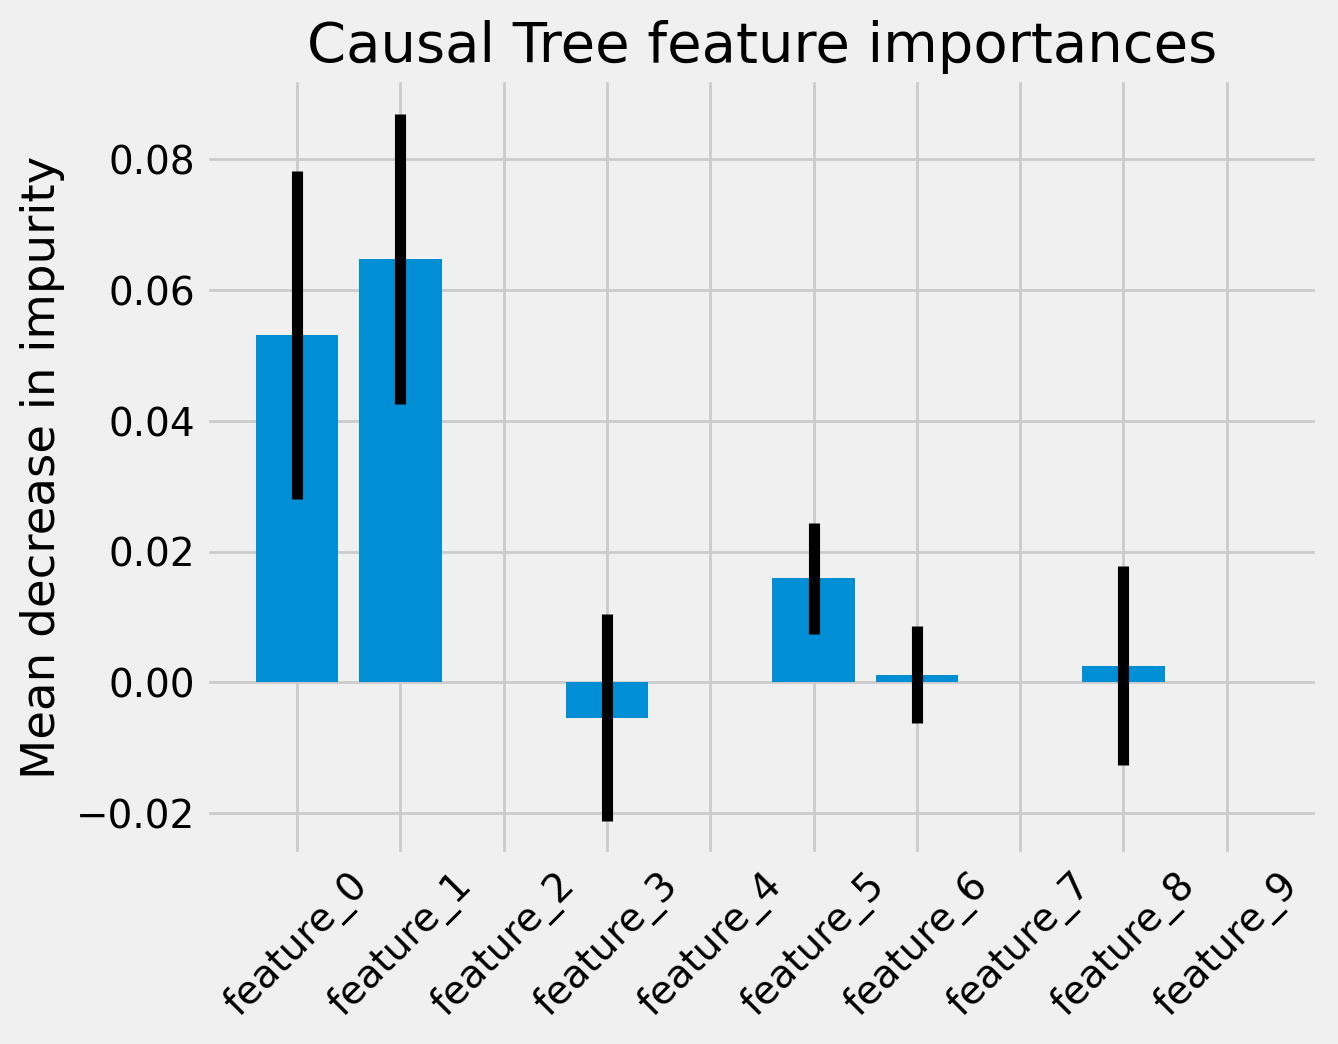

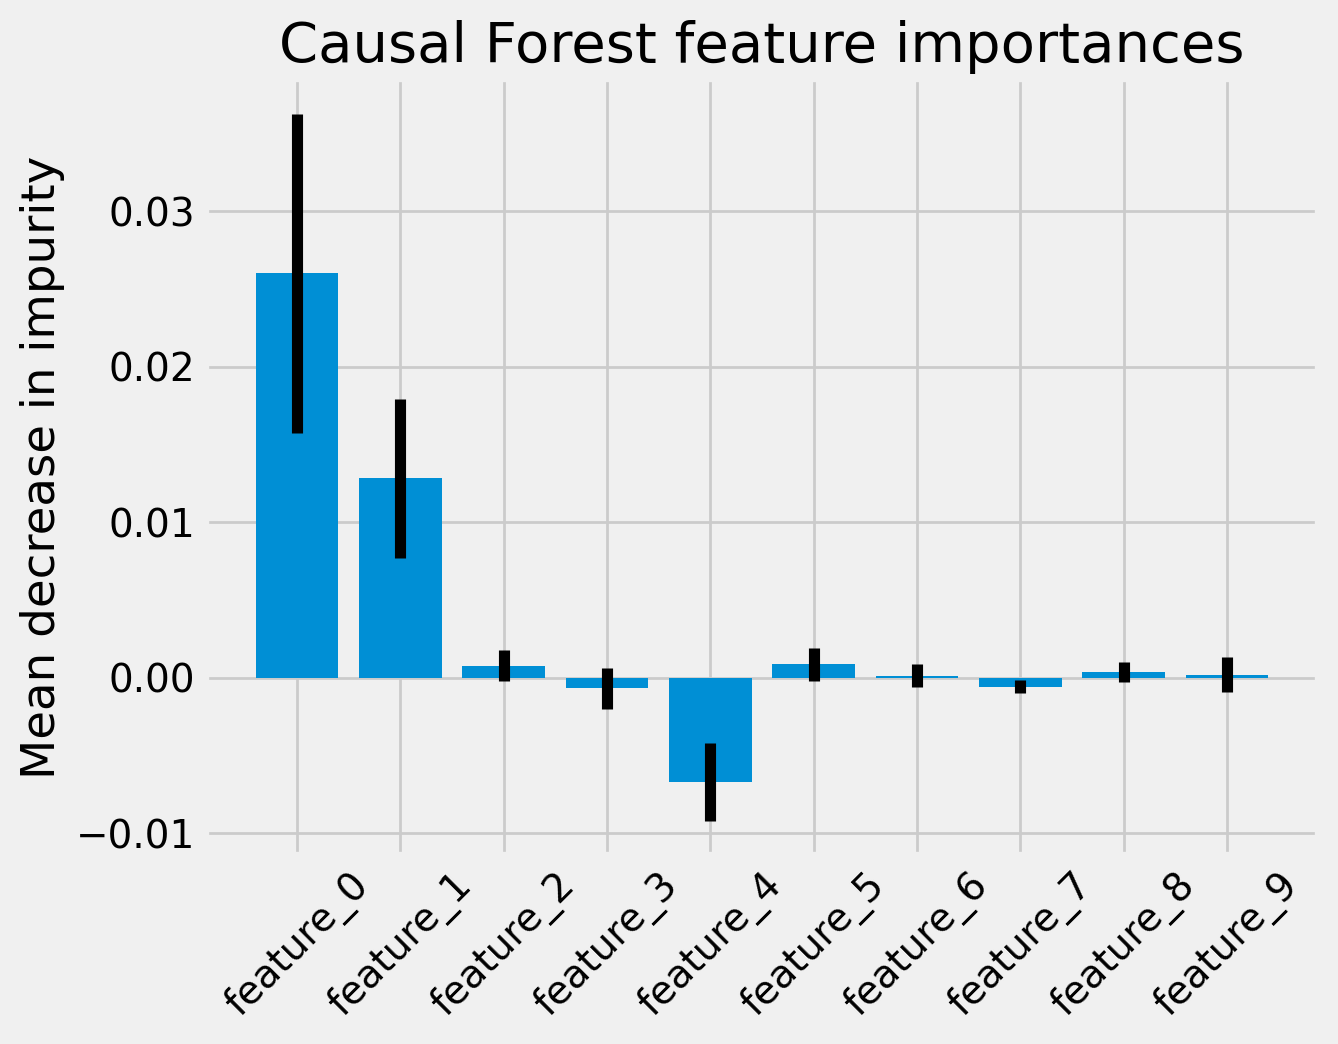

In [9]:
for name, model in zip(('Causal Tree', 'Causal Forest'), (ctree, crforest)):
    
    imp = permutation_importance(model, X_test, y_test,
                                 n_repeats=50,
                                 random_state=0)
    
    fig, ax = plt.subplots()
    ax.set_title(f"{name} feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    plt.bar(feature_names, imp['importances_mean'], yerr=imp['importances_std'])
    ax.set_xticklabels(feature_names, rotation=45)
    plt.show()

### SHAP values

#### TreeExplainer

Details: https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html#shap.TreeExplainer

In [10]:
shap.__version__

'0.40.1.dev831'

CausalTree

In [11]:
tree_explainer = shap.TreeExplainer(ctree)
# Expected values for treatment=0 and treatment=1. i.e. Y|X,T=0 and Y|X,T=1
tree_explainer.expected_value

array([0.93121212, 1.63459276])

In [12]:
tree_explainer

In [13]:
# (Y|X,T=0, Y|X,T=1,  [Y|X,T=1] - [Y|X,T=0])
ctree.predict(observation, with_outcomes=True)

array([[ 2.3146749 ,  2.03953544, -0.27513945]])

In [14]:
observation

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,0.496714,-0.138264,0.647689,1.52303,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.54256


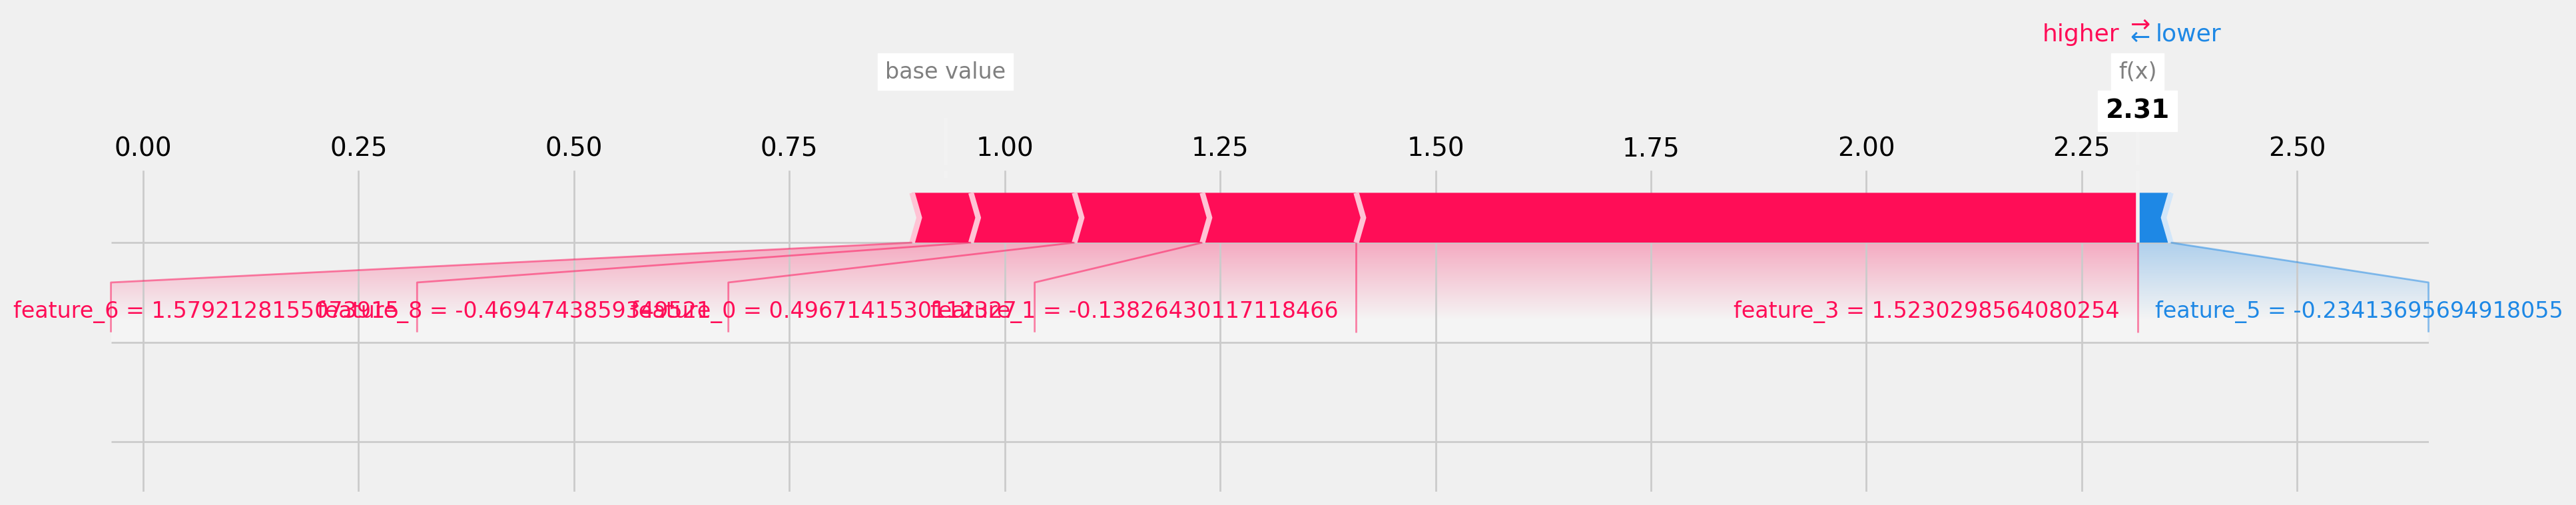

In [15]:
# CausalTree
# Tree Explainer for treatment=0
shap.initjs()

treatment_idx = 0
shap_values = tree_explainer.shap_values(observation)
shap.force_plot(
    base_value=np.array([tree_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation,
    matplotlib=True
)

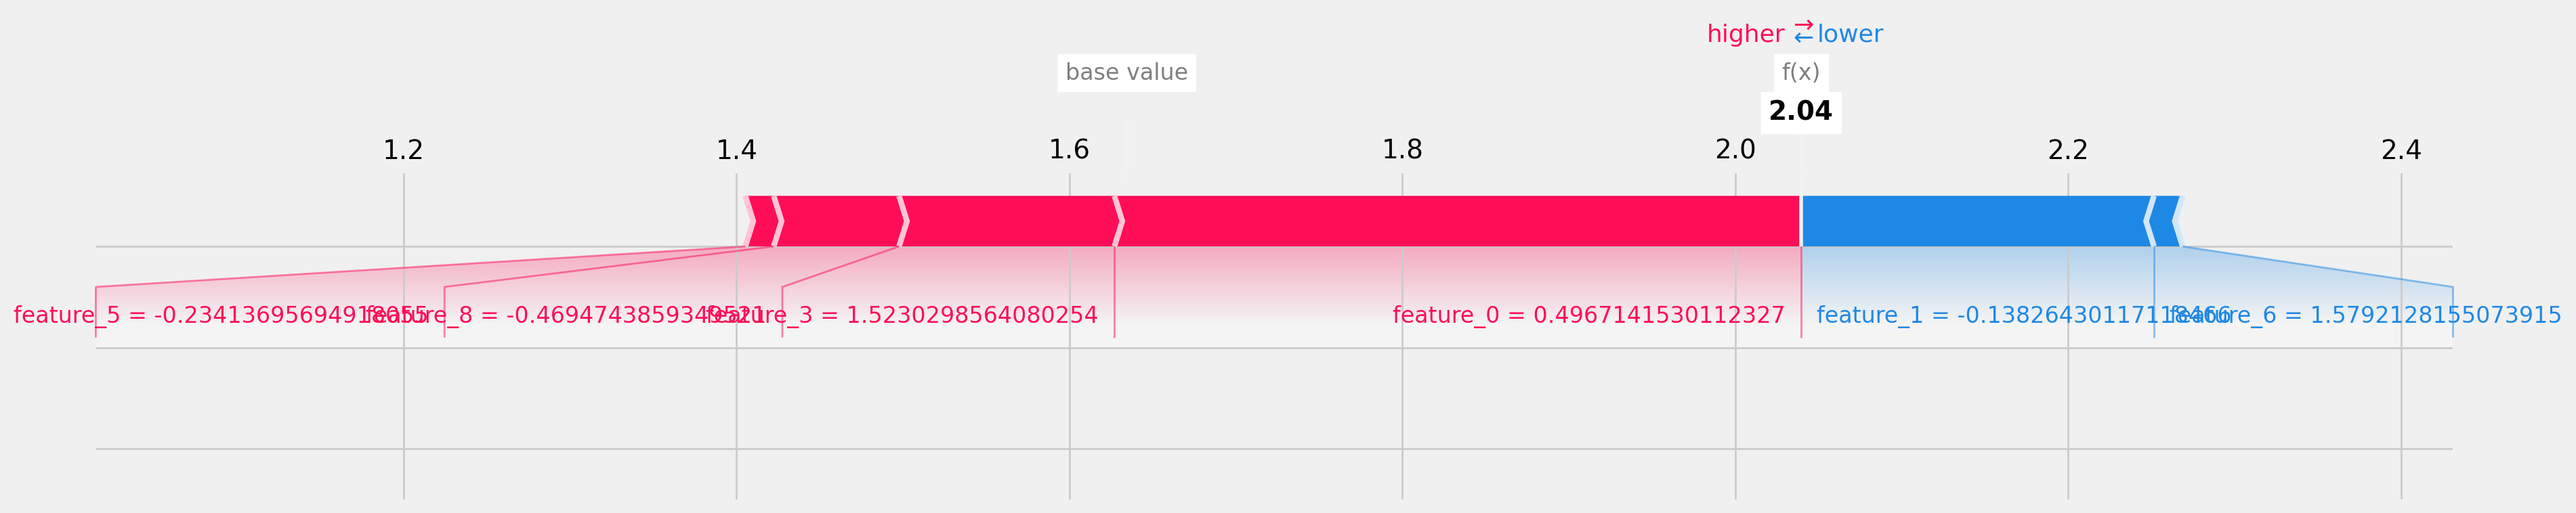

In [16]:
# CausalTree
# Tree Explainer for treatment=1
shap.initjs()

treatment_idx = 1
shap_values = tree_explainer.shap_values(observation)
shap.force_plot(
    base_value=np.array([tree_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation,
    matplotlib=True
)

CausalRandomForest

In [17]:
cforest_explainer = shap.TreeExplainer(crforest)
# Expected values for treatment=0 and treatment=1. i.e. Y|X,T=0 and Y|X,T=1
cforest_explainer.expected_value

array([0.93203354, 1.61854881])

In [18]:
# (Y|X,T=0, Y|X,T=1,  [Y|X,T=1] - [Y|X,T=0])
crforest.predict(observation, with_outcomes=True)

array([[1.11856369, 1.9490421 , 0.83047841]])

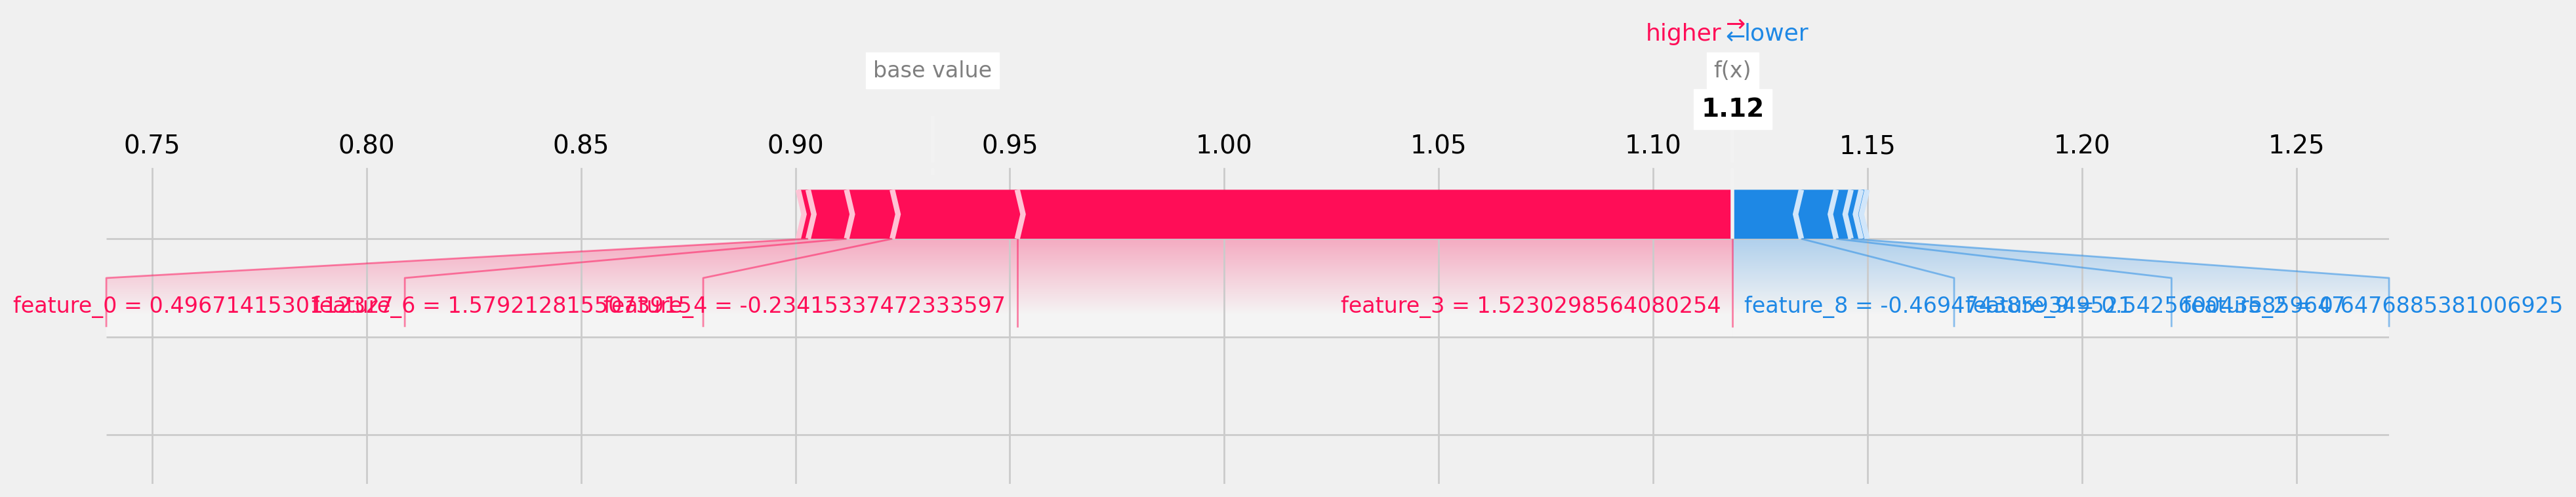

In [19]:
# CausalRandomForest
# Tree Explainer for treatment=0
shap.initjs()

treatment_idx = 0
shap_values = cforest_explainer.shap_values(observation)

shap.force_plot(
    base_value=np.array([cforest_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation,
    matplotlib=True
)

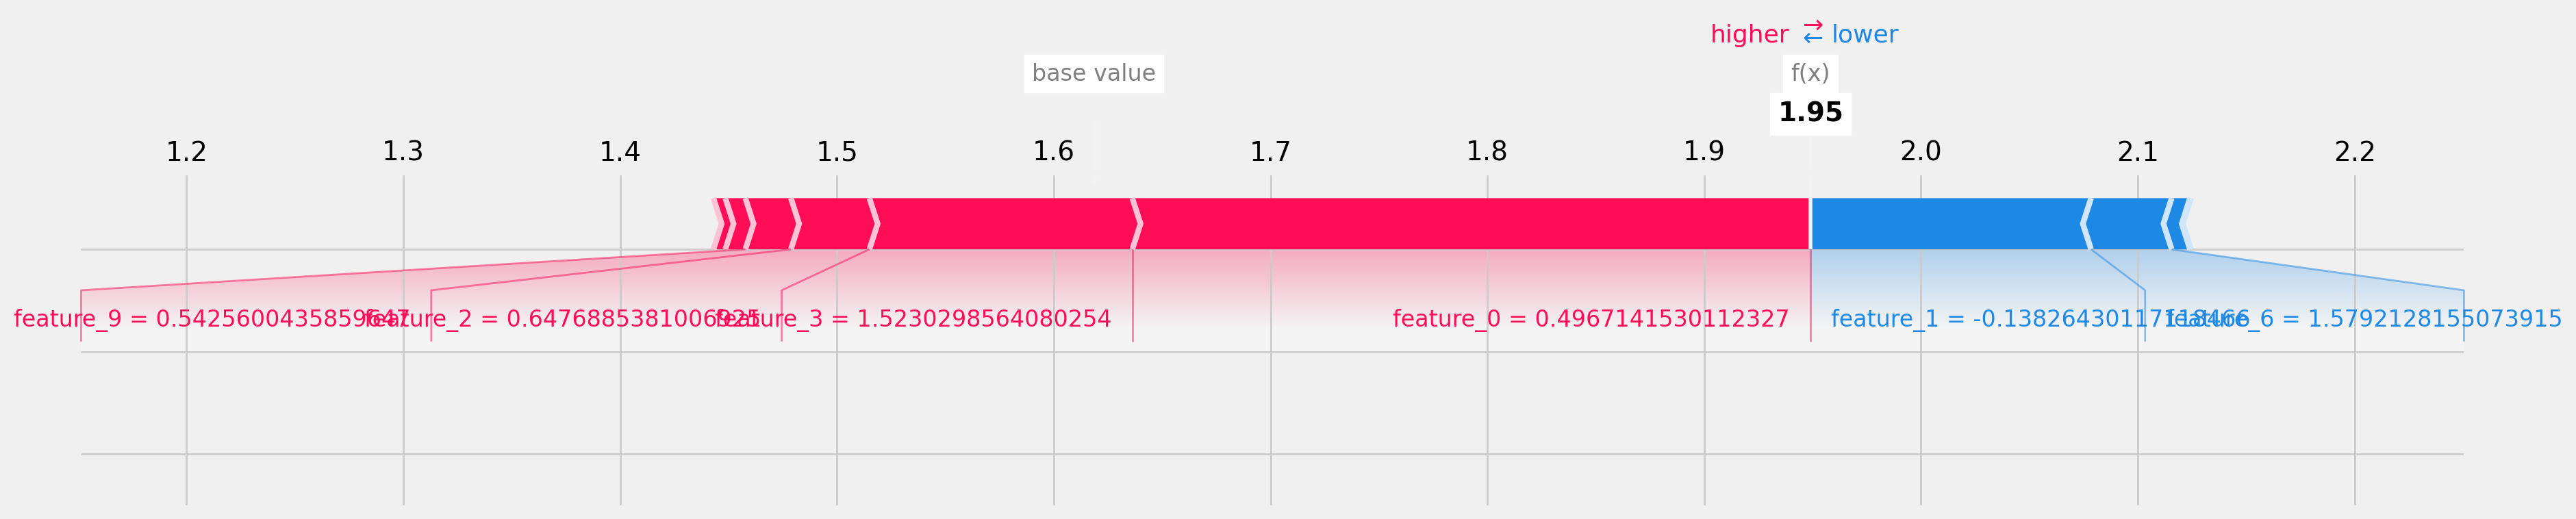

In [20]:
# CausalRandomForest
# Tree Explainer for treatment=1
shap.initjs()

treatment_idx = 1
shap_values = cforest_explainer.shap_values(observation)

shap.force_plot(
    base_value=np.array([cforest_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation,
    matplotlib=True
)

#### Decision plots

CausalTree

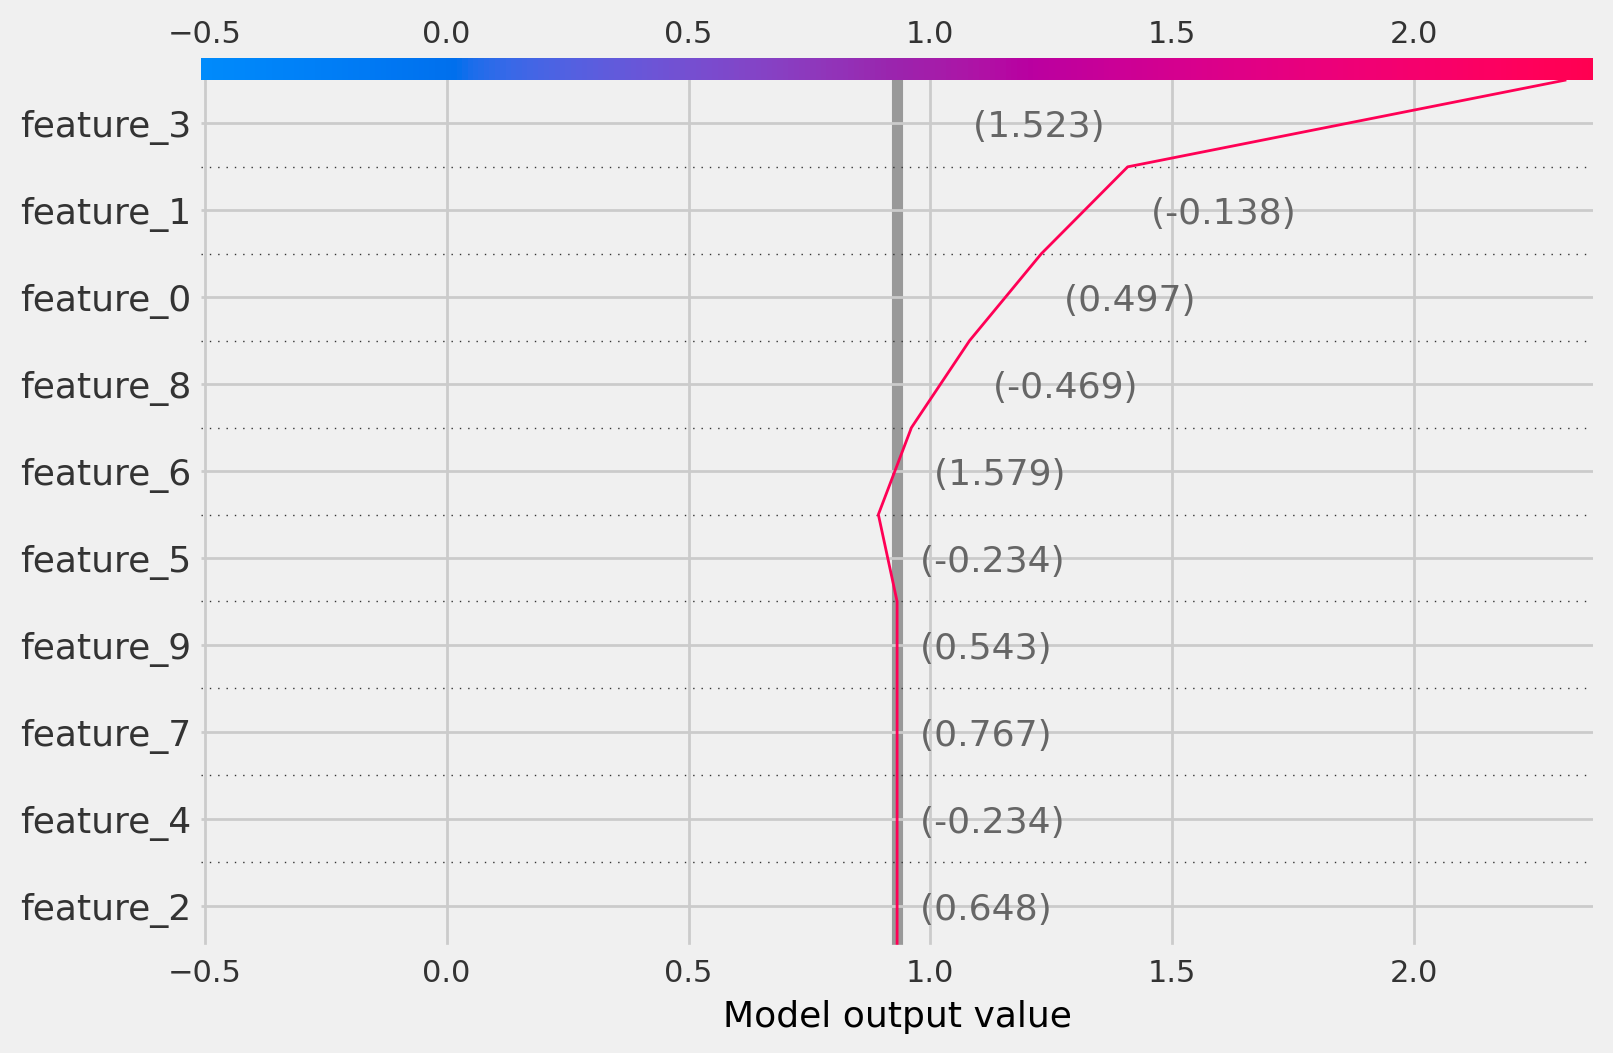

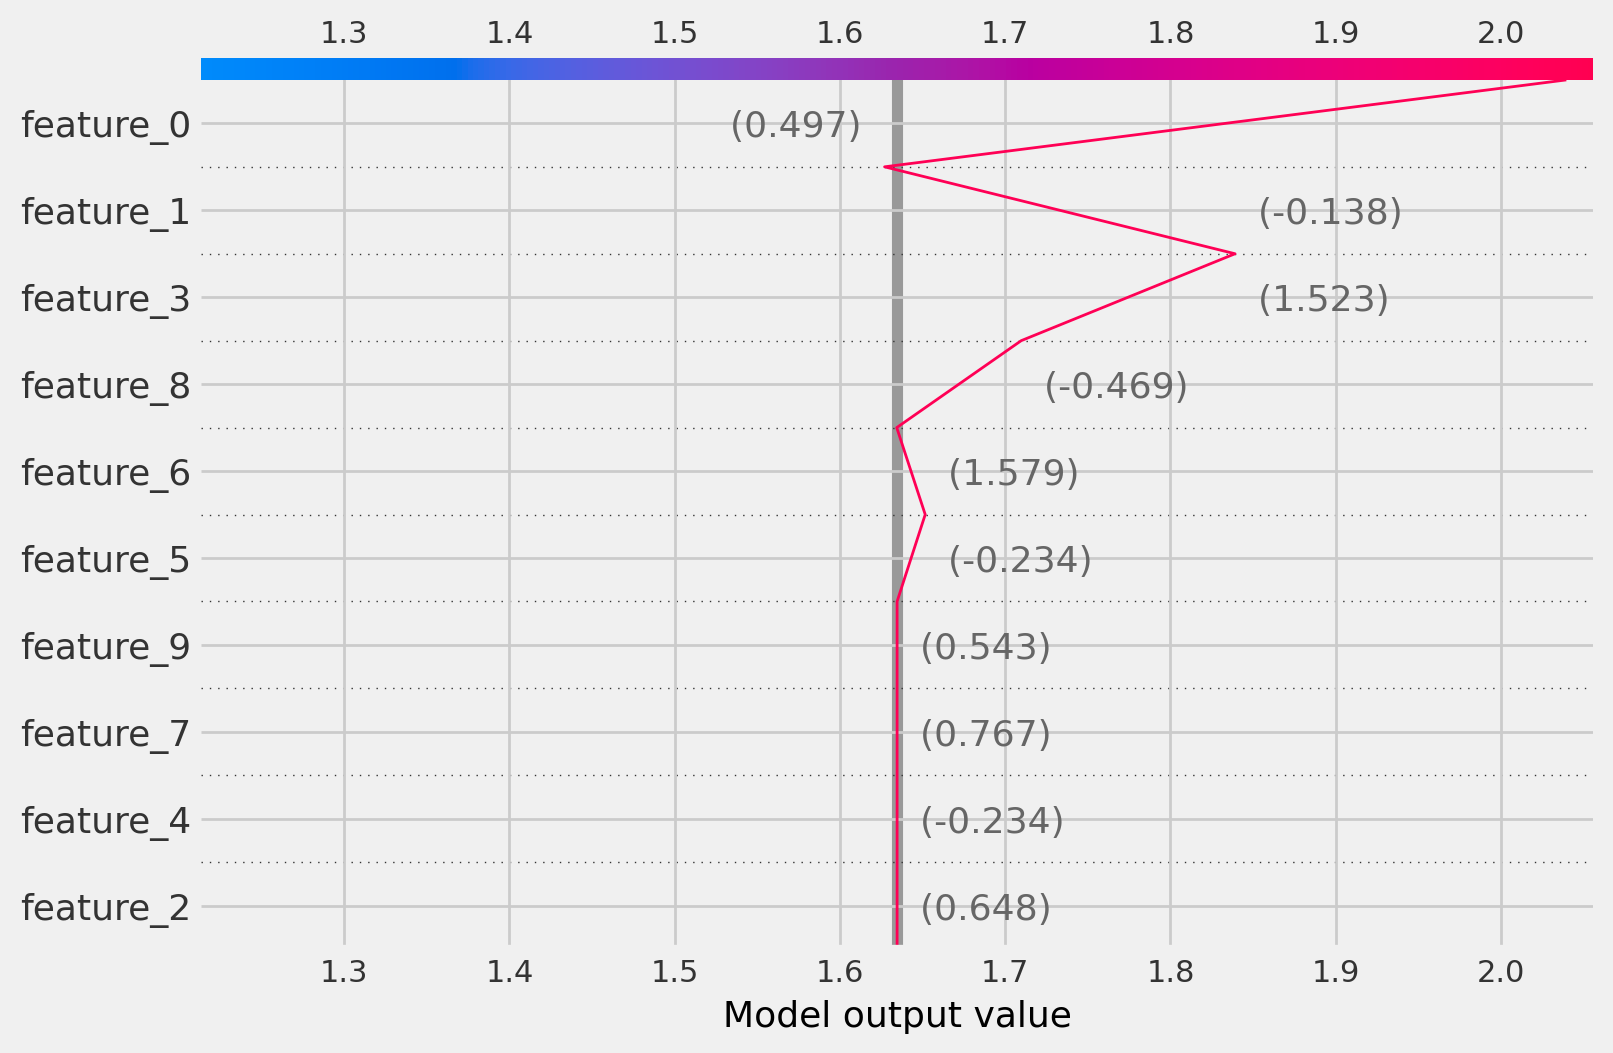

In [21]:
treatment_idx=0
shap_values = tree_explainer.shap_values(observation)
shap.decision_plot(
    base_value=np.array([tree_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation
)
treatment_idx=1
shap.decision_plot(
    base_value=np.array([tree_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation
)

CausalRandomForest

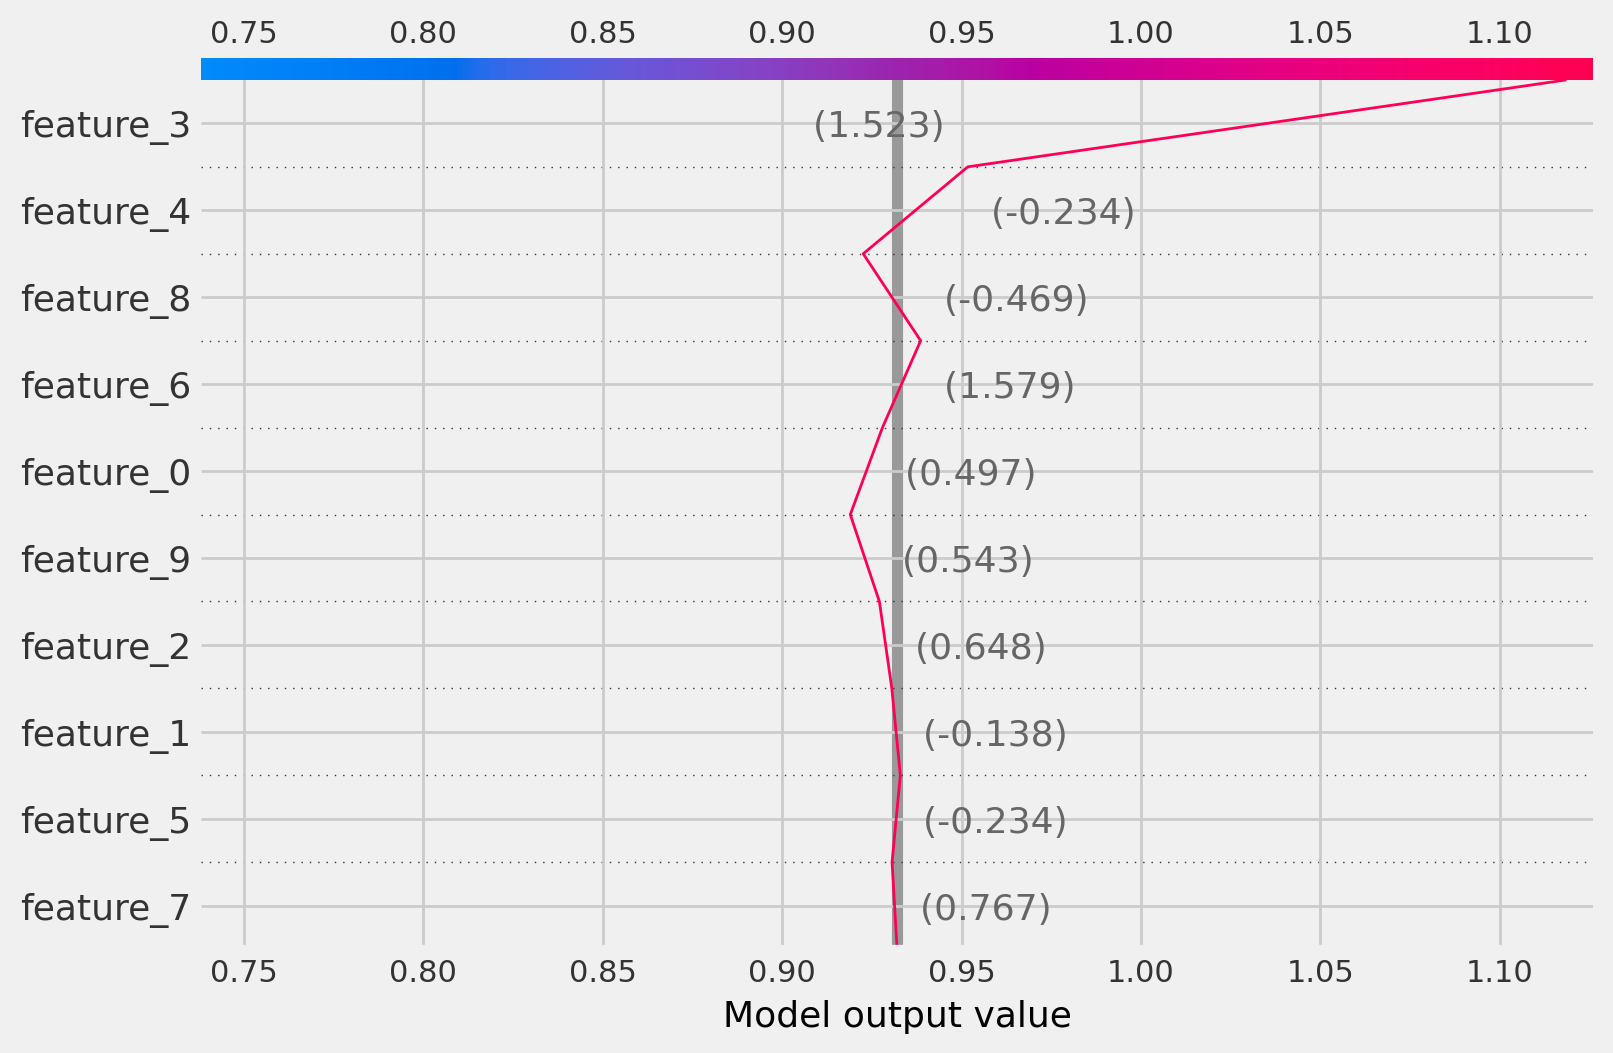

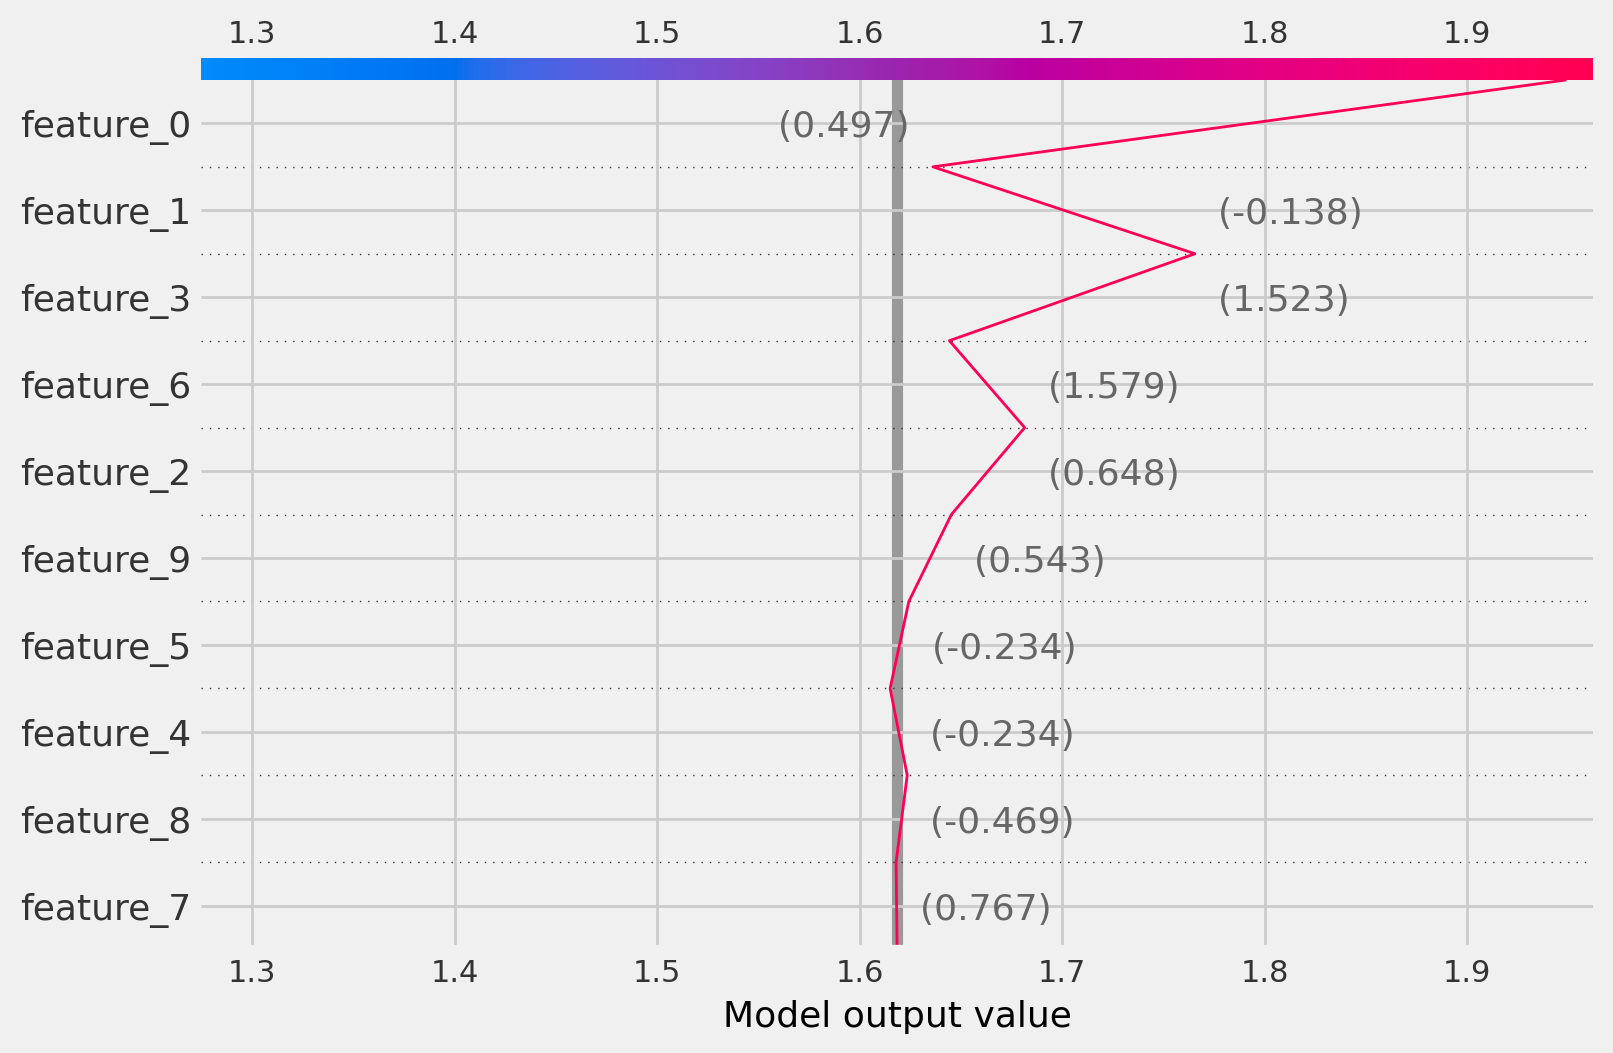

In [22]:
treatment_idx=0
shap_values = cforest_explainer.shap_values(observation)
shap.decision_plot(
    base_value=np.array([cforest_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation
)
treatment_idx=1
shap.decision_plot(
    base_value=np.array([cforest_explainer.expected_value[treatment_idx]]),
    shap_values=shap_values[:, :, treatment_idx],
    features=observation
)

#### Dependence plots

CausalTree

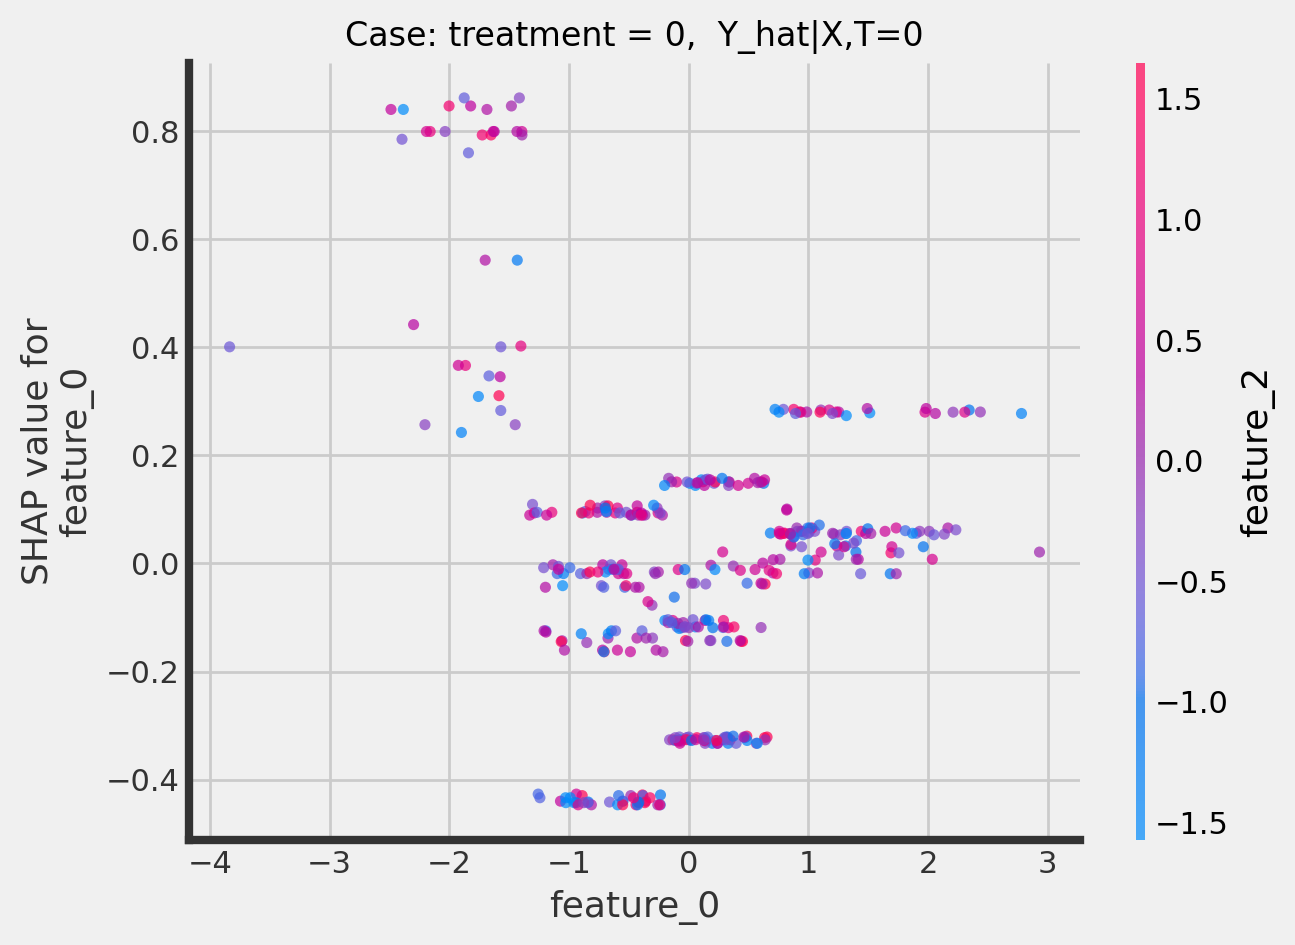

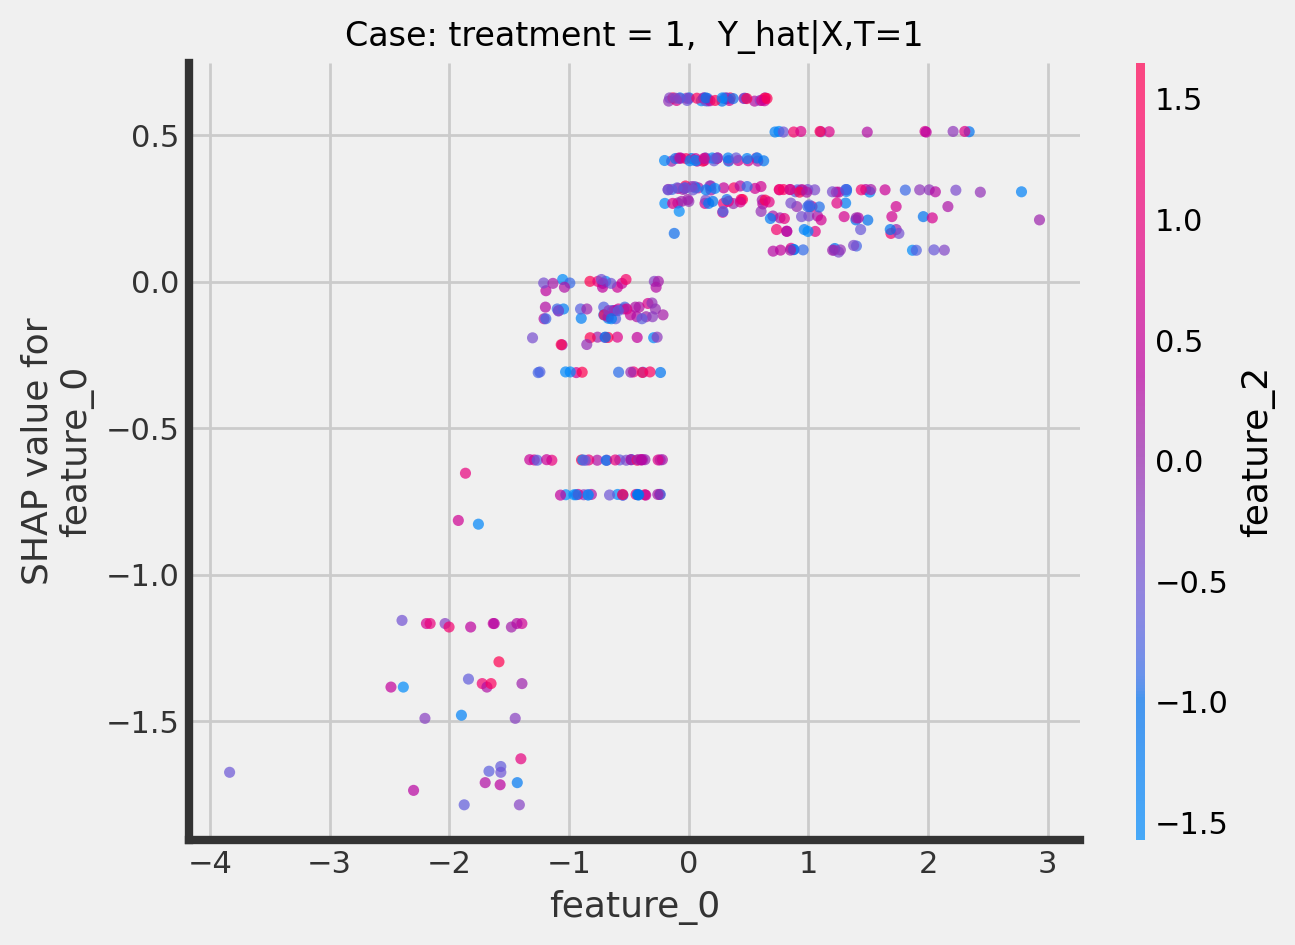

In [23]:
treatment_indices = [0, 1]
for i in treatment_indices:
    fig, ax = plt.subplots()
    ax.set_title(f"Case: treatment = {i},  Y_hat|X,T={i}", fontsize=12)
    shap.dependence_plot(
        "feature_0", 
        tree_explainer.shap_values(X_test)[:, :, i], 
        X_test, 
        interaction_index="feature_2",
        alpha=0.7,
        ax=ax
    )

CausalRandomForest

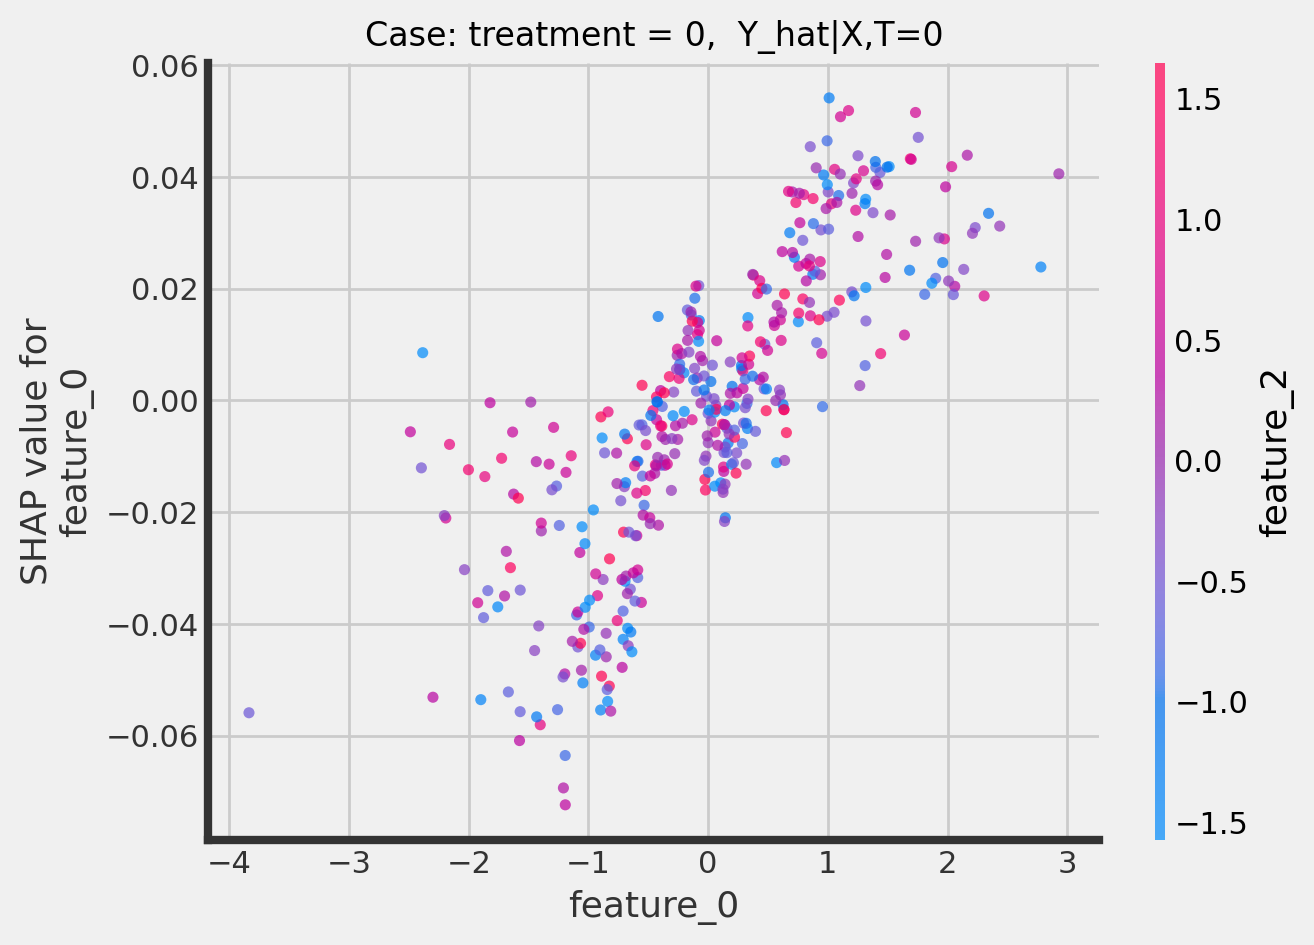

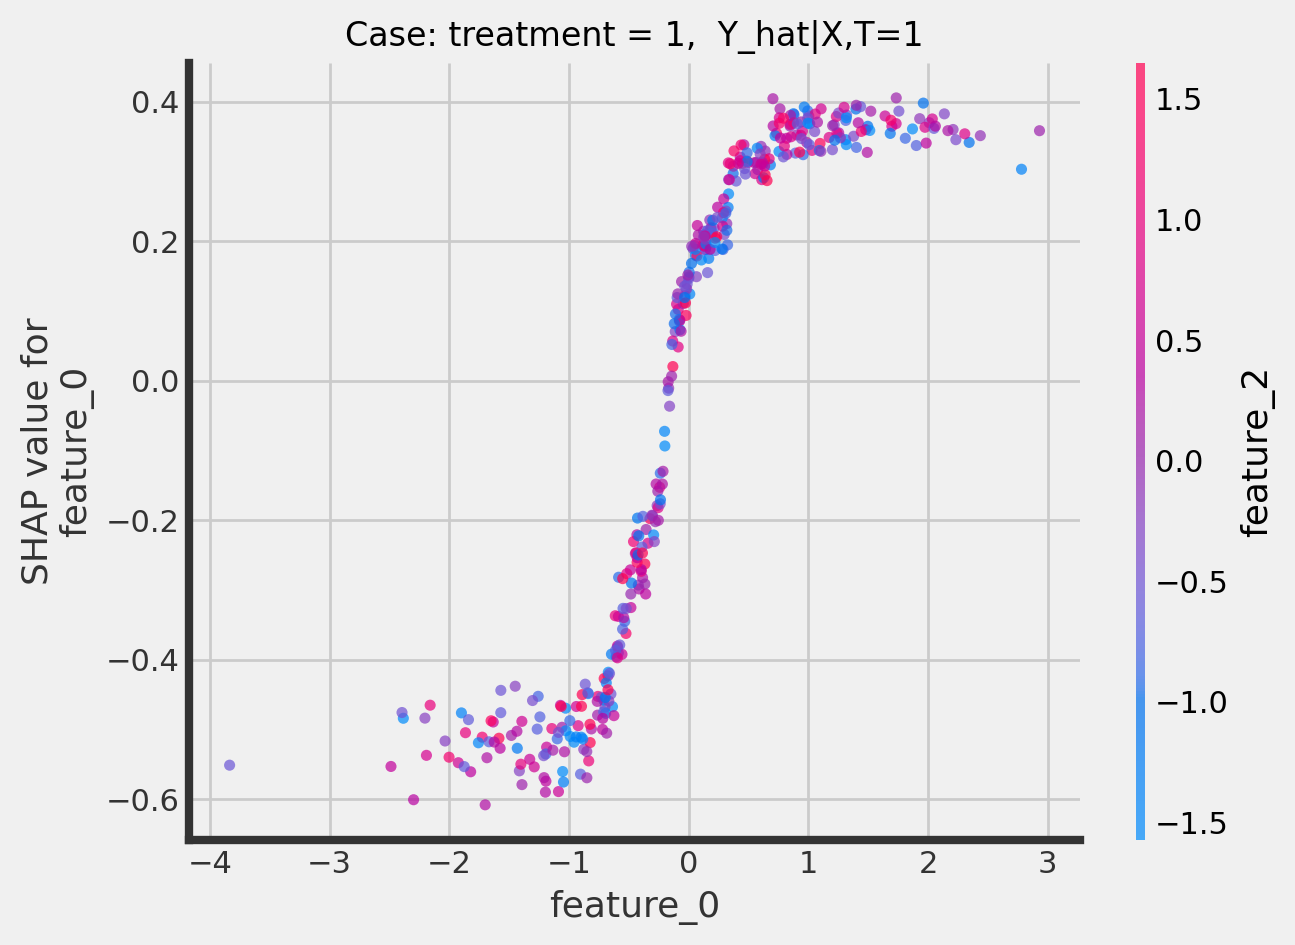

In [24]:
treatment_indices = [0, 1]
for i in treatment_indices:
    fig, ax = plt.subplots()
    ax.set_title(f"Case: treatment = {i},  Y_hat|X,T={i}", fontsize=12)
    shap.dependence_plot(
        "feature_0", 
        cforest_explainer.shap_values(X_test)[:, :, i], 
        X_test, 
        interaction_index="feature_2",
        alpha=0.7,
        ax=ax
    )